In [101]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('..')

import src as sc

COLOR_MAP = {"light_orange":"#E69F00",
             "light_blue":"#56B4E9",
             "teal":"#009E73",
             "yellow":"#F0E442",
             "dark_blue":"#0072B2",
             "dark_orange":"#D55E00",
             "pink":"#CC79A7",
             "purple":"#9370DB",
             "black":"#000000",
             "silver":"#DCDCDC"}

cmap = {"Man":COLOR_MAP["light_blue"],
       "Non-Man":COLOR_MAP["dark_blue"],
       "White":COLOR_MAP["light_orange"],
       "Non-White":COLOR_MAP["dark_orange"]}
lmap = {"Man":"--",
       "Non-Man":"-",
       "White":"--",
       "Non-White":"-"}


# Load Data

In [3]:
# Load data
hall_df, student_df, art_df = sc.load_data()

# Get art_capacity_df.
art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                    categories = ["gender","race"])

# Get building_capacity_df.
building_capacity_df = sc.get_building_capacity_df()
building_capacity =  building_capacity_df.values
art_capacity = art_capacity_df["capacity"].values

# Fill buildings
sc.fill_buildings(student_df = student_df, hall_df = hall_df)

art_capacity_df

,tuple,string,original_index,capacity
0,"(1, 1)","Woman, White",1104,100.0
1,"(1, 2)","Woman, Asian",302,4.0
2,"(1, 3)","Woman, Hispanics of any race",1863,4.0
3,"(1, 4)","Woman, Black or African American",997,7.0
4,"(1, 6)","Woman, American Indian or Alaska Native",1001,15.0
5,"(2, 1)","Man, White",1441,100.0
6,"(2, 2)","Man, Asian",83,35.0
7,"(2, 3)","Man, Hispanics of any race",957,100.0
8,"(2, 4)","Man, Black or African American",1048,54.0
9,"(2, 5)","Man, Two or more races",356,1.0


In [4]:
# Current assigment
current_assignment = pd.read_csv("current_assignment_df.csv", index_col = 0)
current_assignment.sum(axis = 0)

Woman, White                                51
Woman, Asian                                 2
Woman, Hispanics of any race                 0
Woman, Black or African American             0
Woman, American Indian or Alaska Native      0
Man, White                                 285
Man, Asian                                   3
Man, Hispanics of any race                  18
Man, Black or African American              13
Man, Two or more races                       0
Man, American Indian or Alaska Native        0
dtype: int64

In [5]:
# Get baseline stats.
df_baseline = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])
for i in range(50):
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    bs_gender = sc.baseline_average_value(category = "gender", in_group = "Man")
    bs_race = sc.baseline_average_value(category = "race", in_group = "White")
    df_baseline[i] = list(bs_gender) + list(bs_race)
    
df_stats = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

mean = [np.around(d,decimals = 3) for d in df_baseline.mean(axis = 1)]
error = [np.around(d,decimals = 3) for d in df_baseline.std(axis = 1)]

df_stats["baseline_mean"] = mean
df_stats["baseline_error"] = error
df_stats

,baseline_mean,baseline_error
Man,12.301,0.112
Non-Man,2.459,0.021
White,13.363,0.114
Non-White,1.587,0.015


In [6]:
# for i in [1,10,20]:
#     cost_df = sc.compute_cost_matrix(art_df = art_df, 
#                                         hall_df = hall_df,
#                                         categories = ["gender","race"],
#                                         alpha = -1,
#                                         beta = 10**i)

#     C = cost_df.values
#     num_buildings = cost_df.shape[0]
#     num_arts = cost_df.shape[1]
#     building_capacity = building_capacity_df.values
#     art_capacity = art_capacity_df["capacity"].values

#     P = current_assignment.values
#     t = np.trace(np.matmul(C.transpose(),P))
#     print(t)

# Initialize Parameters

#### Calibrate lambda and tau factors

In [7]:
# Current assigment
current_assignment = pd.read_csv("current_assignment_df.csv", index_col = 0).values

df_baseline = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])
num_buildings =  building_capacity_df.shape[0]

# Find the appropriate scaling between the first and second terms of the optimization objective
# Fix alpha = -1
# Vary beta as follows: beta = [0.01 0.1 1 10 100 1000]
# For each beta, compute first term
# Compute second and third terms without lambda
# See on average how large is the first term compared 
# to the second and third terms

#beta_values = np.array([1000,100000,1000000000])
beta_values = np.array([.01,1,10])
term1 = np.zeros((beta_values.shape[0],10))
term2 = np.zeros((beta_values.shape[0],10))
term3 = np.zeros((beta_values.shape[0],10))
for m in range(beta_values.shape[0]):
    # Compute full n_buildings x n_artworks cost matrix.
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta_values[m])
    num_arts = cost_df.shape[1]
    t = np.arange(1,num_arts + 1)
    for k in range(10):
        # Pick a random permutation in S
        P = np.random.randn(num_buildings,num_arts)  
        # Projection
        for ii in range(num_buildings):
            v = P[ii,:]
            if np.all(v>0):
                v = v/np.sum(v)
                P[ii]=v * building_capacity[ii]
            else:
                mu = v[np.argsort(-v)]
                tmp = np.divide(np.cumsum(mu)-building_capacity[ii],t)
                idx_negative = np.argwhere(mu-tmp<=0)
                try:
                    idx_neg = idx_negative[0]
                    idx_neg = idx_neg.item()
                except:
                    idx_neg = -1
                theta = (np.sum(mu[0:idx_neg])-building_capacity[ii])/(idx_neg)
                P[ii,:] =  np.maximum(P[ii,:]-theta,0)  
        term1[m,k] = np.trace(np.matmul(np.transpose(cost_df.values),P))
        term2[m,k] = np.linalg.norm(np.sum(P,axis=0)-art_capacity)**2
        term3[m,k] = np.linalg.norm(P-current_assignment)**2

term1_avg = np.mean(term1)
term2_avg = np.mean(term2)
term3_avg = np.mean(term3)

print(f"term 1 mean = {term1_avg}, std = {np.std(term1)}")
print(f"term 2 mean = {term2_avg}, std = {np.std(term2)}")
print(f"term 3 mean = {term3_avg}, std = {np.std(term3)}")
print(" ")

norm_lam_factor = term1_avg/term2_avg
norm_tau_factor = term1_avg/term3_avg

# norm_lam_factor = 1/ np.std(term2)
# norm_tau_factor = 1/ np.std(term3)

print(f"norm_lam_factor = {norm_lam_factor}")
print(f"norm_tau_factor = {norm_tau_factor}")

term 1 mean = 4.680237793148725, std = 1.8280027541158215
term 2 mean = 31161.698310906206, std = 679.8711395457374
term 3 mean = 33621.138310226735, std = 23.93639387134527
 
norm_lam_factor = 0.00015019200001402684
norm_tau_factor = 0.00013920521518229233


In [8]:
# Current assigment
current_assignment = pd.read_csv("current_assignment_df.csv", index_col = 0).values

df_baseline = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])
num_buildings =  building_capacity_df.shape[0]

# Find the appropriate scaling between the first and second terms of the optimization objective
# Fix alpha = -1
# Vary beta as follows: beta = [0.01 0.1 1 10 100 1000]
# For each beta, compute first term
# Compute second and third terms without lambda
# See on average how large is the first term compared 
# to the second and third terms

beta_values = np.array([1000,100000,1000000000])
term1 = np.zeros((beta_values.shape[0],10))
term2 = np.zeros((beta_values.shape[0],10))
term3 = np.zeros((beta_values.shape[0],10))
for m in range(beta_values.shape[0]):
    # Compute full n_buildings x n_artworks cost matrix.
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta_values[m])
    num_arts = cost_df.shape[1]
    t = np.arange(1,num_arts + 1)
    for k in range(10):
        # Pick a random permutation in S
        P = np.random.randn(num_buildings,num_arts)  
        # Projection
        for ii in range(num_buildings):
            v = P[ii,:]
            if np.all(v>0):
                v = v/np.sum(v)
                P[ii]=v * building_capacity[ii]
            else:
                mu = v[np.argsort(-v)]
                tmp = np.divide(np.cumsum(mu)-building_capacity[ii],t)
                idx_negative = np.argwhere(mu-tmp<=0)
                try:
                    idx_neg = idx_negative[0]
                    idx_neg = idx_neg.item()
                except:
                    idx_neg = -1
                theta = (np.sum(mu[0:idx_neg])-building_capacity[ii])/(idx_neg)
                P[ii,:] =  np.maximum(P[ii,:]-theta,0)  
        term1[m,k] = np.trace(np.matmul(np.transpose(cost_df.values),P))
        term2[m,k] = norm_lam_factor * np.linalg.norm(np.sum(P,axis=0)-art_capacity)**2
        term3[m,k] = norm_tau_factor * np.linalg.norm(P-current_assignment)**2

term1_avg = np.mean(term1)
term2_avg = np.mean(term2)
term3_avg = np.mean(term3)

print(f"term 1 mean = {term1_avg}, std = {np.std(term1)}")
print(f"term 2 mean = {term2_avg}, std = {np.std(term2)}")
print(f"term 3 mean = {term3_avg}, std = {np.std(term3)}")
print(" ")

term 1 mean = 4.595146894031416, std = 1.5607191686771897
term 2 mean = 4.657265208168893, std = 0.1230492412955192
term 3 mean = 4.680236476331134, std = 0.0032380999972231052
 


# Choose Optimal lambda and tau Parameters

In [27]:
cost_dict = {}
opt_dict = {}
assignment_dict = {}

betas = []

#### beta = 0.01

In [151]:
beta = 0.01
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [152]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 
        
        assignment_dict[f"{beta}_{lam}_{tau}"] = assignment_df.values.reshape(1,-1)

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

#### beta = 100

In [102]:
beta = 100
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [103]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 
        assignment_dict[f"{beta}_{lam}_{tau}"] = assignment_df.values.reshape(1,-1)

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

#### beta = 10^8

In [104]:
beta = 10**8
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [105]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 
        assignment_dict[f"{beta}_{lam}_{tau}"] = assignment_df.values.reshape(1,-1)
        
        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

#### beta = 10^11

In [106]:
beta = 10 ** 11
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [107]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 
        assignment_dict[f"{beta}_{lam}_{tau}"] = assignment_df.values.reshape(1,-1)

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

#### beta = 10 ^15

In [108]:
beta = 10 ** 15
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [109]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 
        
        assignment_dict[f"{beta}_{lam}_{tau}"] = assignment_df.values.reshape(1,-1)

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

INFO:matplotlib.mathtext:Substituting symbol G from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol G from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol G from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol G from STIXNonUnicode


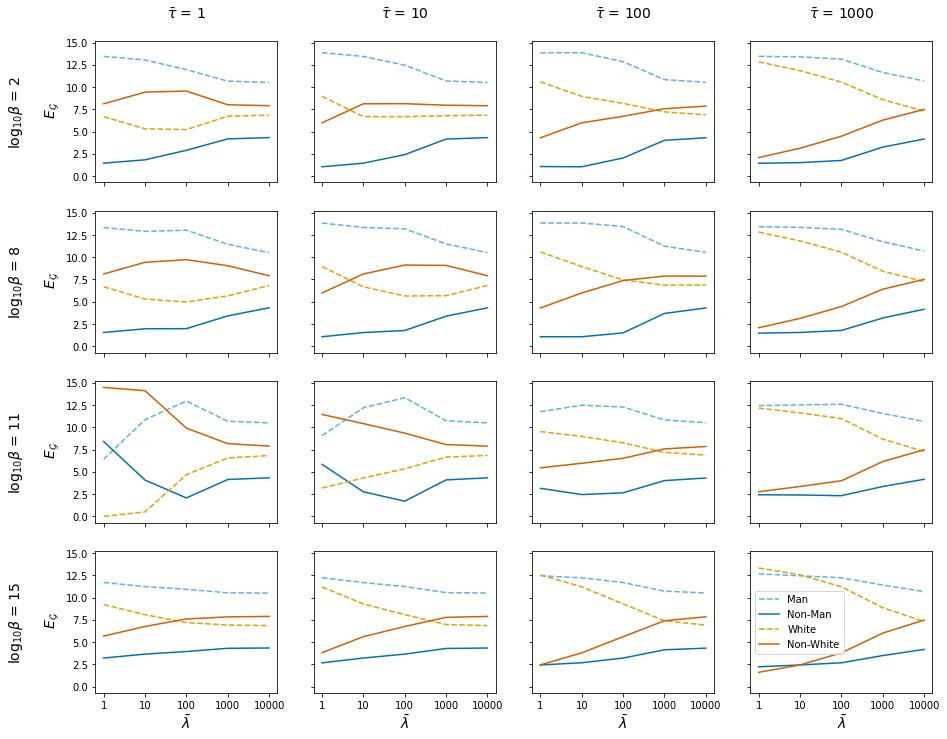

In [155]:
bbetas = [10**2, 10**8, 10**11, 10**15]

cmap = {"Man":COLOR_MAP["light_blue"],
       "Non-Man":COLOR_MAP["dark_blue"],
       "White":COLOR_MAP["light_orange"],
       "Non-White":COLOR_MAP["dark_orange"]}
lmap = {"Man":"--",
       "Non-Man":"-",
       "White":"--",
       "Non-White":"-"}

fig, ax = plt.subplots(len(bbetas),4,figsize = (15,12), sharex = True, sharey = True)

for i in range(len(bbetas)):
    beta = bbetas[i]
    df_optimized = opt_dict[beta]
    for j in range(len(scaled_tau)):
        tau = scaled_tau[j]
        tau_idx = [d for d in df_optimized.index if float(d.split("_")[2]) == tau]
        for c in df_optimized.columns:
            ax[i, j].plot(df_optimized.loc[tau_idx,c].values, 
                                   color = cmap[c],
                                   linestyle = lmap[c], 
                                   label = c)
            ax[i, j].set_xticks([i for i in range(len(scaled_lam))])
            ax[i, j].set_xticklabels(scaled_lam)

ax[i, j].legend()
for i in range(len(bbetas)):
    ax[i,0].set_ylabel(r"log$_{10}\beta$"+f" = {int(np.log10(bbetas[i]))}\n \n"+r" $E_\mathcal{G}$", fontsize = 14)
for j in range(len(scaled_tau)):
    ax[0, j].set_title(r"$\bar{\tau}$"+f" = {scaled_tau[j]}\n", fontsize = 14)
    ax[-1, j].set_xlabel(r'$\bar{\lambda}$', fontsize = 14)
    
plt.show()

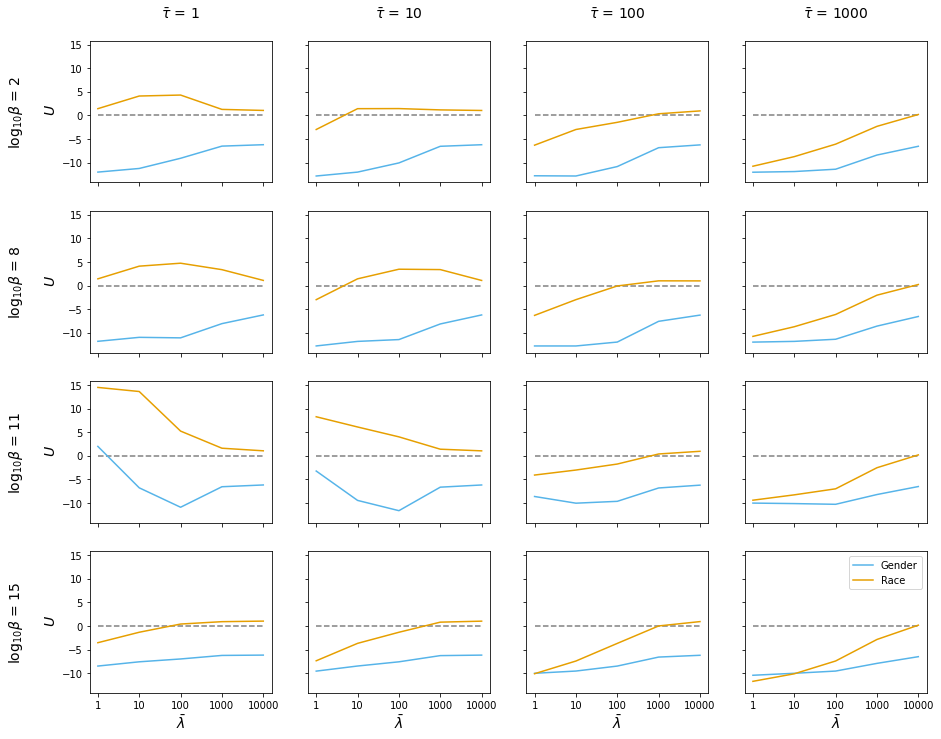

In [156]:
bbetas = [10**2, 10**8, 10**11, 10**15]

cmap = {"Man":COLOR_MAP["light_blue"],
       "Non-Man":COLOR_MAP["dark_blue"],
       "White":COLOR_MAP["light_orange"],
       "Non-White":COLOR_MAP["dark_orange"]}
lmap = {"Man":"--",
       "Non-Man":"-",
       "White":"--",
       "Non-White":"-"}

fig, ax = plt.subplots(len(bbetas),4,figsize = (15,12), sharex = True, sharey = True)

for i in range(len(bbetas)):
    beta = bbetas[i]
    df_optimized = opt_dict[beta]
    for j in range(len(scaled_tau)):
        tau = scaled_tau[j]
        tau_idx = [d for d in df_optimized.index if float(d.split("_")[2]) == tau]
        #for c in df_optimized.columns:
        x = df_optimized.loc[tau_idx,"Non-Man"].values - df_optimized.loc[tau_idx,"Man"].values
        ax[i,j].plot(x, color = cmap["Man"], label = "Gender")
        
        x = df_optimized.loc[tau_idx,"Non-White"].values - df_optimized.loc[tau_idx,"White"].values
        ax[i,j].plot(x, color = cmap["White"], label = "Race")
        ax[i, j].set_xticks([i for i in range(len(scaled_lam))])
        ax[i, j].set_xticklabels(scaled_lam)
        ax[i,j].plot(pd.Series(0, index = tau_idx).values, zorder = 0, 
                     linestyle = "--", 
                     color = "grey")

ax[i, j].legend()
for i in range(len(bbetas)):
    ax[i,0].set_ylabel(r"log$_{10}\beta$"+f" = {int(np.log10(bbetas[i]))}\n \n"+r" $U$", fontsize = 14)
for j in range(len(scaled_tau)):
    ax[0, j].set_title(r"$\bar{\tau}$"+f" = {scaled_tau[j]}\n", fontsize = 14)
    ax[-1, j].set_xlabel(r'$\bar{\lambda}$', fontsize = 14)
    
plt.show()

# Gather Statistics

In [130]:
lam = 1000
tau = 100
beta = 100

num = 50

In [131]:
df_optimized_2 = pd.DataFrame(index = [i for i in range(num)], columns = ["Man","Non-Man","White","Non-White"])
for i in range(num):
    
    # Fill buildings
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    
    # Load data
    hall_df, student_df, art_df = sc.load_data()

    # Get art_capacity_df.
    art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                        categories = ["gender","race"])

    # Get building_capacity_df.
    building_capacity_df = sc.get_building_capacity_df()
    building_capacity =  building_capacity_df.values
    art_capacity = art_capacity_df["capacity"].values
    
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)
    
    assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 

    # Get optimized stats.
    os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
    os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
    df_optimized_2.loc[i,:] = list(os_gender) + list(os_race)

In [132]:
df_stats_2 = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

mean = [np.around(d,decimals = 3) for d in df_optimized_2.mean(axis = 0)]
error = [np.around(d,decimals = 3) for d in df_optimized_2.std(axis = 0)]

df_stats_2["baseline_mean"] = mean
df_stats_2["baseline_error"] = error
df_stats_2

,baseline_mean,baseline_error
Man,10.705,0.094
Non-Man,4.035,0.035
White,7.213,0.091
Non-White,7.575,0.070


In [133]:
df_optimized_3 = pd.DataFrame(index = [i for i in range(num)], columns = ["Man","Non-Man","White","Non-White"])
for i in range(num):
    
    # Fill buildings
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    
    # Load data
    hall_df, student_df, art_df = sc.load_data()

    # Get art_capacity_df.
    art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                        categories = ["gender","race"])

    # Get building_capacity_df.
    building_capacity_df = sc.get_building_capacity_df()
    building_capacity =  building_capacity_df.values
    art_capacity = art_capacity_df["capacity"].values
    
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)
    
    assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=3) 

    # Get optimized stats.
    os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
    os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
    df_optimized_3.loc[i,:] = list(os_gender) + list(os_race)

In [134]:
df_stats_3 = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

mean = [np.around(d,decimals = 3) for d in df_optimized_3.mean(axis = 0)]
error = [np.around(d,decimals = 3) for d in df_optimized_3.std(axis = 0)]

df_stats_3["baseline_mean"] = mean
df_stats_3["baseline_error"] = error
df_stats_3

,baseline_mean,baseline_error
Man,10.743,0.111
Non-Man,4.031,0.034
White,7.210,0.069
Non-White,7.585,0.049


In [135]:
df_optimized_4 = pd.DataFrame(index = [i for i in range(num)], columns = ["Man","Non-Man","White","Non-White"])
for i in range(num):
    
    # Fill buildings
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    
    # Load data
    hall_df, student_df, art_df = sc.load_data()

    # Get art_capacity_df.
    art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                        categories = ["gender","race"])

    # Get building_capacity_df.
    building_capacity_df = sc.get_building_capacity_df()
    building_capacity =  building_capacity_df.values
    art_capacity = art_capacity_df["capacity"].values
    
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)
    
    assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=4) 

    # Get optimized stats.
    os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
    os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
    df_optimized_4.loc[i,:] = list(os_gender) + list(os_race)

In [137]:
df_stats_4 = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

mean = [np.around(d,decimals = 3) for d in df_optimized_4.mean(axis = 0)]
error = [np.around(d,decimals = 3) for d in df_optimized_4.std(axis = 0)]

df_stats_4["baseline_mean"] = mean
df_stats_4["baseline_error"] = error
df_stats_4

,baseline_mean,baseline_error
Man,10.704,0.105
Non-Man,4.044,0.032
White,7.219,0.075
Non-White,7.583,0.062


# Verify Large values of tau

In [19]:
lam = 1000
tau = 10000
beta = 100

cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)
    
assignment_df = sc.learn_optimal_assignment(cost_df, 
                         building_capacity_df, 
                         art_capacity_df, 
                         current_assignment, 
                         lam = norm_lam_factor*lam, 
                         tau=norm_tau_factor*tau, 
                         init=4) 

os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")

In [20]:
os_gender

(12.341635010696013, 2.5465423407070364)

In [21]:
os_race

(11.04550119523513, 3.9465847840608554)

In [26]:
assignment_df.values.reshape(1,-1)

array([[28.760538811764267, 1.2114265441709855, 0.2838662808735913,
        0.4967659915287853, 1.0644985532759679, 163.80165598599555,
        4.182088872281851, 13.117070959431139, 7.662756596309906,
        0.07096657021839782, 1.3483648341495593, 0.26653437538651775, 0,
        0, 0, 0, 0, 0, 1.59822130981093, 0.13524431480255222, 0, 0,
        6.7402032124200755, 0.21128126274295717, 0.2815595275274151,
        0.49272917317297693, 1.0558482282278074, 14.915723850884225,
        2.167502412714045, 4.097770140436339, 4.629584554237083,
        0.07038988188185377, 1.3374077557552224, 0, 0, 0, 0, 0, 0, 0,
        0.6553069775117096, 0.34469302248829037, 0, 0,
        0.3341565327877939, 0, 0, 0, 0, 0, 0, 0.665843467212206, 0, 0, 0,
        1.1042722411416692, 0, 0, 0, 0, 0, 0.48678640273454643,
        2.435959175566082, 0.972982180557703, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1.0, 0, 0, 0, 0.5998677087198514, 0, 0, 0, 0, 0, 0,
        1.9315546431442632, 0.4685776481358856, 0, 0, 5.76

## Spectral Clustering

In [216]:
from sklearn.manifold import SpectralEmbedding
keys = [k for k in list(assignment_dict.keys()) if float(k.split("_")[-1]) != 0.1]
keys = [k for k in keys if float(k.split("_")[1]) != 0.1]

n_trials = len(keys)
n_features = list(assignment_dict.values())[0][0].shape[0]

data = np.empty((n_trials, n_features))
print(data.shape)
i = 0

for k in keys:
    print(k)
    v = assignment_dict[k]
    data[i] = v[0]
    i = i+1
data

(100, 242)
0.01_1_1
0.01_1_10
0.01_1_100
0.01_10_1
0.01_10_10
0.01_10_100
0.01_100_1
0.01_100_10
0.01_100_100
0.01_1000_1
0.01_1000_10
0.01_1000_100
100_1_1
100_1_10
100_1_100
100_1_1000
100_10_1
100_10_10
100_10_100
100_10_1000
100_100_1
100_100_10
100_100_100
100_100_1000
100_1000_1
100_1000_10
100_1000_100
100_1000_1000
100_10000_1
100_10000_10
100_10000_100
100_10000_1000
100000000_1_1
100000000_1_10
100000000_1_100
100000000_1_1000
100000000_10_1
100000000_10_10
100000000_10_100
100000000_10_1000
100000000_100_1
100000000_100_10
100000000_100_100
100000000_100_1000
100000000_1000_1
100000000_1000_10
100000000_1000_100
100000000_1000_1000
100000000_10000_1
100000000_10000_10
100000000_10000_100
100000000_10000_1000
100000000000_1_1
100000000000_1_10
100000000000_1_100
100000000000_1_1000
100000000000_10_1
100000000000_10_10
100000000000_10_100
100000000000_10_1000
100000000000_100_1
100000000000_100_10
100000000000_100_100
100000000000_100_1000
100000000000_1000_1
100000000000_1000

array([[0.00000000e+00, 5.22698924e+00, 4.48164638e+00, ...,
        8.10269940e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.11914370e+00, 3.18922823e+00, ...,
        1.01271545e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.00440602e+00, 3.02333021e+00, ...,
        3.59020903e-01, 0.00000000e+00, 1.62108543e-01],
       ...,
       [5.02413590e+01, 2.02548805e+00, 2.02334339e+00, ...,
        4.93581014e-01, 9.14045562e-03, 1.73705283e-01],
       [4.98083254e+01, 2.00992928e+00, 1.98893143e+00, ...,
        5.01518794e-01, 9.33125987e-03, 1.77325702e-01],
       [4.62949965e+01, 1.88343077e+00, 1.70976884e+00, ...,
        5.68825807e-01, 1.09697248e-02, 2.08432312e-01]])

In [217]:
COLORS = {'light_orange': '#E69F00',
 'light_blue': '#56B4E9',
 'teal': '#009E73',
 'yellow': '#F0E442',
 'dark_blue': '#0072B2',
 'dark_orange': '#D55E00',
 'pink': '#CC79A7',
 'purple': '#9370DB',
 'black': '#000000',
 'silver': '#DCDCDC'}

cmap_beta = {
    "0.01": "light_orange",
    "100":"teal",
    "100000000":"yellow",
    "100000000000":"pink",
    "1000000000000000":"purple"
}

cmap_lam = {
    "1":"light_orange",
    "10":"teal",
    "100":"yellow",
    "1000":"pink",
    "10000":"purple"
}

cmap_tau = {
    "1":"light_orange",
    "10":"teal",
    "100":"yellow",
    "1000":"pink"
}


beta_colors = []
lam_colors = []
tau_colors = []
#"beta_lam_tau"
for k in keys:
    beta_colors.append(COLORS[cmap_beta[k.split("_")[0]]])
    lam_colors.append(COLORS[cmap_lam[k.split("_")[1]]])
    tau_colors.append(COLORS[cmap_tau[k.split("_")[2]]])

In [218]:
X = np.empty((data.shape[0], data.shape[0]))
for i in range(data.shape[0]):
    for j in range(data.shape[0]):
        X[i,j] = np.abs(data[i,:] - data[j,:]).sum()
        X[i,i] = 1
X

array([[  1.        , 158.65141834, 282.20519931, ..., 373.584153  ,
        367.09950188, 315.83222385],
       [158.65141834,   1.        , 133.72677756, ..., 367.22962683,
        363.129468  , 330.46098504],
       [282.20519931, 133.72677756,   1.        , ..., 405.863386  ,
        403.92065926, 388.66954181],
       ...,
       [373.584153  , 367.22962683, 405.863386  , ...,   1.        ,
          7.8049969 ,  70.52789541],
       [367.09950188, 363.129468  , 403.92065926, ...,   7.8049969 ,
          1.        ,  62.72289851],
       [315.83222385, 330.46098504, 388.66954181, ...,  70.52789541,
         62.72289851,   1.        ]])

In [219]:
# from sklearn.cluster import SpectralClustering

# XX = (1/X) - np.eye(X.shape[0])

# sc = SpectralClustering(n_clusters=3, affinity = "precomputed", assign_labels='kmeans')
# sc.fit(XX)

# labels = sc.labels_
# # Plot output

# cmap = ["green","red","blue"]
# color = [cmap[i] for i in labels]
# plt.scatter(data[:,0],data[:,1], c = color)
# plt.show()

In [220]:
XX = (1/X) - np.eye(X.shape[0])
XX

array([[0.        , 0.00630313, 0.00354352, ..., 0.00267677, 0.00272406,
        0.00316624],
       [0.00630313, 0.        , 0.00747793, ..., 0.00272309, 0.00275384,
        0.00302608],
       [0.00354352, 0.00747793, 0.        , ..., 0.00246388, 0.00247573,
        0.00257288],
       ...,
       [0.00267677, 0.00272309, 0.00246388, ..., 0.        , 0.12812305,
        0.01417879],
       [0.00272406, 0.00275384, 0.00247573, ..., 0.12812305, 0.        ,
        0.01594314],
       [0.00316624, 0.00302608, 0.00257288, ..., 0.01417879, 0.01594314,
        0.        ]])

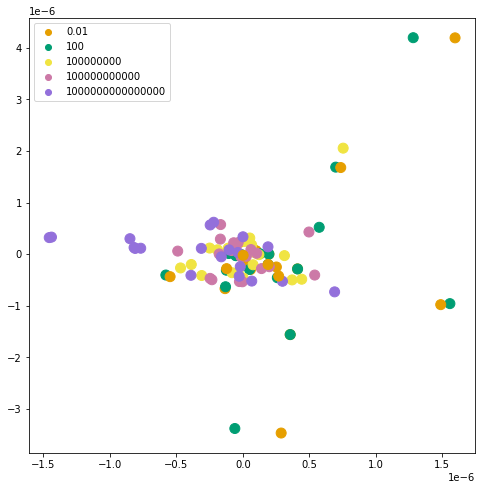

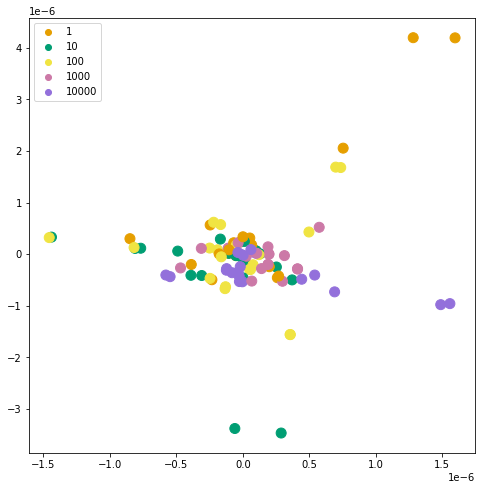

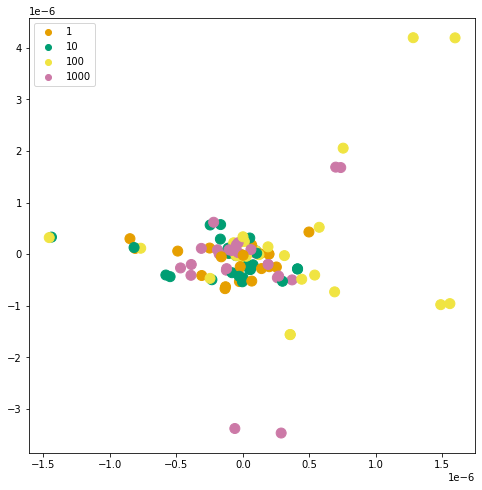

In [225]:
embedding = SpectralEmbedding(n_components=2, affinity = "precomputed", random_state = 42)
X_transformed = embedding.fit_transform(XX)


fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(X_transformed[:,0], X_transformed[:,1], c = beta_colors, s = 100)
for k in cmap_beta.keys():
    ax.scatter([],[], label = k, color = COLORS[cmap_beta[k]])
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(X_transformed[:,0], X_transformed[:,1], c = lam_colors, s = 100)
for k in cmap_lam.keys():
    ax.scatter([],[], label = k, color = COLORS[cmap_lam[k]])
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(X_transformed[:,0], X_transformed[:,1], c = tau_colors, s = 100)
for k in cmap_tau.keys():
    ax.scatter([],[], label = k, color = COLORS[cmap_tau[k]])
plt.legend()
plt.show()

In [193]:
X_transformed

array([[ 1.47834421e-07, -3.94193245e-08],
       [-9.69823271e-08, -2.32410983e-08],
       [ 1.96965753e-08,  1.67570435e-07],
       [ 2.14923203e-08,  1.72930207e-07],
       [ 3.17487855e-08,  1.64478134e-07],
       [ 1.47834421e-07, -3.94193245e-08],
       [-9.69823271e-08, -2.32410983e-08],
       [ 2.11748488e-08,  1.72398358e-07],
       [ 2.39196691e-08,  1.78092243e-07],
       [ 2.77804216e-08,  1.77707513e-07],
       [ 2.85274801e-08,  1.74369612e-07],
       [ 1.90808651e-08,  1.70355237e-07],
       [ 2.38400643e-08,  1.80313210e-07],
       [ 2.38455687e-08,  1.80342392e-07],
       [ 2.39921631e-08,  1.81176437e-07],
       [ 2.93565632e-08,  4.69854782e-07],
       [ 2.38403503e-08,  1.80328610e-07],
       [ 2.38404761e-08,  1.80329331e-07],
       [ 2.38442911e-08,  1.80351206e-07],
       [ 2.39730713e-08,  1.81127783e-07],
       [ 3.97464483e-08,  1.48039757e-07],
       [ 1.64128322e-09,  1.34894639e-07],
       [ 1.96955097e-08,  1.67587304e-07],
       [ 2.